In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from medmnist import BloodMNIST as bt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [3]:
def get_data_loaders(batch_size=64):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5],std=[.5])
    ])

    train=bt(split='train',transform=transform,download=True)
    val=bt(split='val',transform=transform,download=True)
    test=bt(split='test',transform=transform,download=True)

    train_loader=DataLoader(train,batch_size=batch_size,shuffle=True)
    val_loader=DataLoader(val,batch_size=batch_size)
    test_loader=DataLoader(train,batch_size=batch_size)
    
    return train_loader,val_loader,test_loader


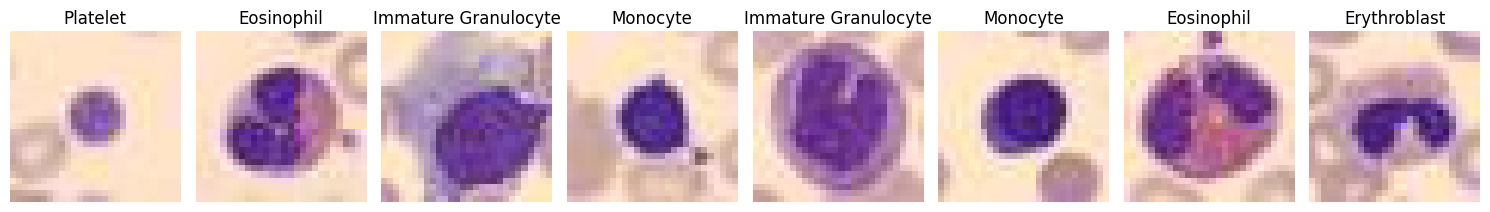

In [4]:
classes = [f"Class {i}" for i in range(8)]  # BloodMNIST has 8 classes

def show_sample_images(data_loader):
    images, labels = next(iter(data_loader))
    images = images[:8]
    labels = labels[:8]
    classes = [
    "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
    "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"]

    fig, axes = plt.subplots(1, 8, figsize=(15, 3))
    
    for i in range(8):
        img = images[i].numpy()
        img = np.transpose(img, (1, 2, 0))  # CHW to HWC
        img = (img * 0.5) + 0.5  # Unnormalize

        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        
        axes[i].imshow(img.squeeze(), cmap='gray') 
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

train_loader, val_loader, test_loader = get_data_loaders()
show_sample_images(train_loader)

In [7]:

def train_model(model, train_loader, val_loader, epochs=20, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"\nEpoch {epoch+1}/{epochs} | Training Loss: {total_loss:.4f}")

        #  Evaluate on validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")


In [8]:

model = BloodCNN()
train_model(model, train_loader, val_loader, epochs=20)


Epoch 1/20 | Training Loss: 156.1016
Validation Accuracy: 84.17%

Epoch 2/20 | Training Loss: 80.4543
Validation Accuracy: 85.40%

Epoch 3/20 | Training Loss: 65.6691
Validation Accuracy: 86.04%

Epoch 4/20 | Training Loss: 55.9033
Validation Accuracy: 89.84%

Epoch 5/20 | Training Loss: 50.6054
Validation Accuracy: 90.42%

Epoch 6/20 | Training Loss: 48.5200
Validation Accuracy: 90.83%

Epoch 7/20 | Training Loss: 40.5703
Validation Accuracy: 91.76%

Epoch 8/20 | Training Loss: 38.7637
Validation Accuracy: 90.42%

Epoch 9/20 | Training Loss: 34.2006
Validation Accuracy: 89.60%

Epoch 10/20 | Training Loss: 31.0418
Validation Accuracy: 92.35%

Epoch 11/20 | Training Loss: 28.5712
Validation Accuracy: 91.82%

Epoch 12/20 | Training Loss: 25.7143
Validation Accuracy: 92.70%

Epoch 13/20 | Training Loss: 23.5890
Validation Accuracy: 91.82%

Epoch 14/20 | Training Loss: 21.6773
Validation Accuracy: 93.57%

Epoch 15/20 | Training Loss: 18.0475
Validation Accuracy: 92.93%

Epoch 16/20 | Tra

In [9]:
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
        "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"
    ]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
        "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
        "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"
    ], yticklabels=[
        "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
        "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"
    ])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(" Confusion Matrix")
    plt.show()


Classification Report:
                      precision    recall  f1-score   support

          Neutrophil       1.00      0.94      0.97       852
          Eosinophil       1.00      1.00      1.00      2181
            Basophil       0.96      1.00      0.98      1085
          Lymphocyte       0.95      0.98      0.97      2026
            Monocyte       1.00      0.96      0.98       849
Immature Granulocyte       0.99      0.94      0.97       993
        Erythroblast       0.99      1.00      1.00      2330
            Platelet       1.00      1.00      1.00      1643

            accuracy                           0.99     11959
           macro avg       0.99      0.98      0.98     11959
        weighted avg       0.99      0.99      0.99     11959



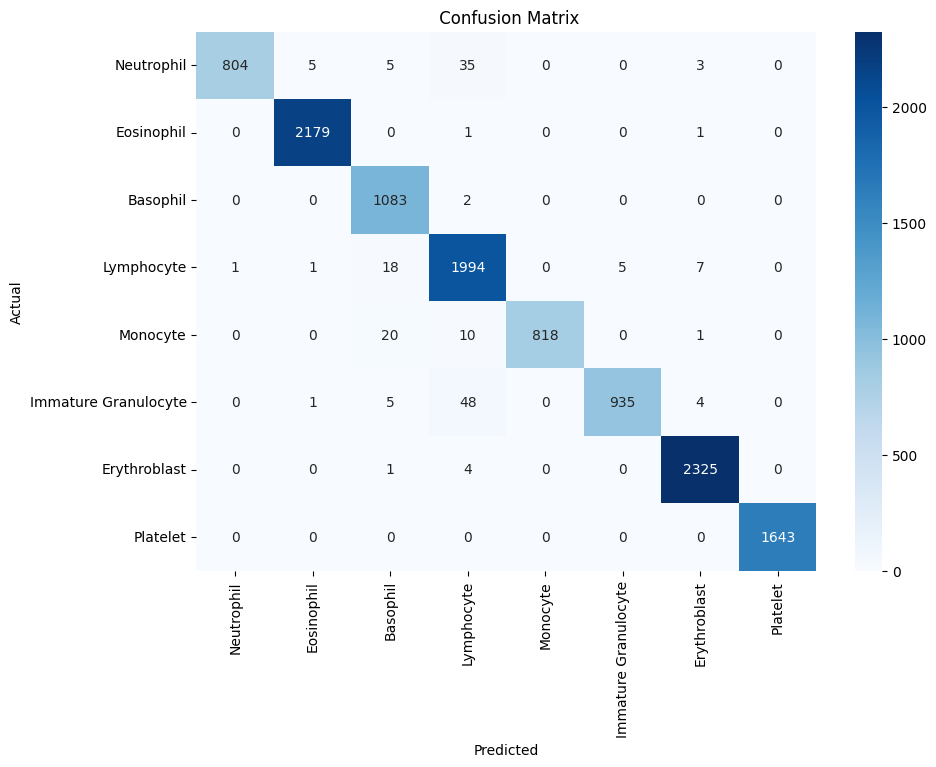

In [10]:
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
torch.save(model.state_dict(), "bloodcnn.pth")

In [ ]:
import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

SyntaxError: invalid syntax (594562107.py, line 4)

In [16]:
classes = [
    "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
    "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"
]

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

st.title("🩸 Blood Cell Classifier")
uploaded_file = st.file_uploader("Upload a blood cell image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        prediction = classes[predicted.item()]

    st.success(f"Predicted Blood Cell Type: **{prediction}** 🧬")

2025-04-27 19:38:04.041 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-27 19:38:04.427 
  command:

    streamlit run C:\Users\janet\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-27 19:38:04.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-27 19:38:04.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-27 19:38:04.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-27 19:38:04.439 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-27 19:38:04.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-27 19:38:04.443 Thre